**Get data**

In [ ]:
# download the dataset 
# !gdown https://drive.google.com/uc?id=1Y4HWIEaZc8lQuf1SAYarGT2cBBrH7mnT
# !unzip cats.zip

#!gdown https://drive.google.com/drive/folders/1AaQMi4jsAItFYmHzPe9p9YNS0IhBjvKo?usp=sharing
#!unzip CATS_INTERP_FULL.zip

#!gdown https://drive.google.com/uc?id=1Fxh2yS6Mk09GZV7et5Cj-MpYmo3BCb-n
#!unzip cats.zip
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# Mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import necessary libraries**

In [ ]:
# Import required packages and libraries:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import cv2
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np
import PIL
from PIL import Image

**Dataset class**

In [ ]:
# data loader
class StereoDataset(Dataset):
  def __init__(self, data_dir,
               device,
               dataset_name = 'CATS',
               mode = 'train',
               transform=None
               ):
    super(StereoDataset, self).__init__()
    self.data_dir     = data_dir
    self.dataset_name = dataset_name
    self.mode         = mode
    self.transform    = transform
    self.device       = device

    cats_data_dict = {
        'train': 'filenames/cats_train.txt',
        'val'  : 'filenames/cats_val.txt',
        'test' : 'filenames/cats_test.txt' 
    }

    cmu_data_dict = {
        'train': 'drive/MyDrive/filenames_cmu/filenames/cmu_train.txt',
        'val'  : 'drive/MyDrive/filenames_cmu/filenames/cmu_val.txt',
        'test' : 'drive/MyDrive/filenames_cmu/filenames/cmu_test.txt' 
    }

    dataset_name_dict = {
        'CATS': cats_data_dict,
        'CMU': cmu_data_dict,
    }

    assert dataset_name in dataset_name_dict.keys()

    self.left_imgs, self.right_imgs, self.gt_imgs = self.get_file_names(dataset_name_dict[dataset_name][mode])

  def get_file_names(self, file_name_list):
    f = open(file_name_list, 'r')
    f = f.readlines()       
    left_arr, right_arr, gt_arr = [], [], []

    for line in f:

      line      = line.split('\n')[0]
      left_img  = self.data_dir + 'left/'  + line
      right_img = self.data_dir + 'right/' + line
      gt_img    = self.data_dir + 'disp/'  + line

      gt_arr.append(gt_img)
      left_arr.append(left_img)
      right_arr.append(right_img)

    return left_arr, right_arr, gt_arr

  def __getitem__(self, index):
    left_img_path  = self.left_imgs[index]
    right_img_path = self.right_imgs[index]
    gt_img_path    = self.gt_imgs[index]

    # Open .tiff image and read it in numpy array
    left = Image.open(left_img_path)
    right = Image.open(right_img_path)
    disp = Image.open(gt_img_path)
    left_img = np.asarray(left)
    right_img = np.asarray(right)
    disp_img = np.asarray(disp)

    left_img  = torch.from_numpy(left_img.astype(float)).float().permute(2, 0, 1)
    right_img = torch.from_numpy(right_img.astype(float)).float().permute(2, 0, 1)
    disp_img  = torch.from_numpy((disp_img.astype(float))).float()
    # print(left_img.shape)
    if self.transform is not None:
      left_img, right_img, disp_img = self.transform(left_img), self.transform(right_img), self.transform(disp_img)
    
    return left_img, right_img, disp_img
  
  def __len__(self):
    return len(self.left_imgs)

**Model architecture**

In [ ]:
# Basic residual block from Kaimeng He's Resnet Paper:

class residual_block(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride,padding,dilation):
    super(residual_block, self).__init__()

    self.in_channels = in_channel
    self.out_channels = out_channel
    self.stride = stride
    self.dilation = dilation

    layers = [nn.Conv2d(in_channel, out_channel, kernel, stride, padding, dilation = dilation), nn.BatchNorm2d(out_channel),nn.ELU(),
              nn.Conv2d(out_channel, out_channel, kernel, 1, padding,dilation=dilation), nn.BatchNorm2d(out_channel)]

    self.layers = nn.Sequential(*layers)


  def forward(self,x):
    if self.in_channels == self.out_channels: # if-else block deals with the condition when number of channels change across residual/skip connection
      input = x
    else:
      diff = self.out_channels - self.in_channels
      x1 = torch.zeros(x.shape[0],diff,x.shape[2],x.shape[3]).to(device)
      input = torch.cat((x,x1),dim=1)

    if self.stride == 2: # Downsample input tensor when number of channels change across residual connections and stride is 2.
      input = F.max_pool2d(input,kernel_size = 2,stride = 2)

    output = self.layers(x)

    output += input # PSM-Net paper does not use ReLU after skip connection
    return output

In [ ]:
# CNN module of PSMNet:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()

    layers_1 = [
              nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = 3, stride = 2, padding = 1), nn.BatchNorm2d(32),nn.ELU(),   # H/2 x W/2 x 32 Conv0_1
              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(32),nn.ELU(), # H/2 x W/2 x 32 Conv0_2
              nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(32),nn.ELU(), # H/2 x W/2 x 32 Conv0_3
              residual_block(32,32,3,1,1,1), residual_block(32,32,3,1,1,1), residual_block(32,32,3,1,1,1), # H/2 x W/2 x 32 Conv1_ 1-3
              residual_block(32,64,3,2,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), # Conv2_ 1-4
              residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), # Conv2_ 5-8
              residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), # Conv2_ 9-12
              residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1), residual_block(64,64,3,1,1,1) # H/4 x W/4 x 64 Conv2_ 13-16
              ]
              
    layers_2 = [      
              residual_block(64,128,3,1,2,2), residual_block(128,128,3,1,2,2), residual_block(128,128,3,1,2,2), # H/4 x W/4 x 64 Conv3_ 1-3
              residual_block(128,128,3,1,4,4), residual_block(128,128,3,1,4,4), residual_block(128,128,3,1,4,4) # H/4 x W/4 x 64 Conv4_ 1-3 
              ]

    # Split sequential block into two lists to extract intermediate outputs for concatentaion in subsequent modules:

    self.layers_1 = nn.Sequential(*layers_1)
    self.layers_2 = nn.Sequential(*layers_2)

  def forward(self,x):
    #pdb.set_trace()
    cnn_concat1 = self.layers_1(x)
    cnn_concat2 = self.layers_2(cnn_concat1)
    return cnn_concat1,cnn_concat2 # Return two outputs(used further in concat operation)


In [ ]:
# SPP module of PSMNet:

class SPP(nn.Module):
  def __init__(self):
    super(SPP,self).__init__()

    self.cnn_module = CNN()

    self.branch1 = nn.Sequential(
                  nn.AvgPool2d(64,stride=64),
                  nn.Conv2d(in_channels = 128,out_channels = 32, kernel_size = 1, stride = 1, padding = 0, dilation = 1), nn.BatchNorm2d(32), nn.ELU()
                  ) # branch_1

    self.branch2 = nn.Sequential(
                  nn.AvgPool2d(32,stride=32),
                  nn.Conv2d(in_channels = 128,out_channels = 32, kernel_size = 1, stride = 1, padding = 0, dilation = 1), nn.BatchNorm2d(32), nn.ELU()
                  ) # branch_2

    self.branch3 = nn.Sequential(
                  nn.AvgPool2d(16,stride=16),
                  nn.Conv2d(in_channels = 128,out_channels = 32, kernel_size = 1, stride = 1, padding = 0, dilation = 1), nn.BatchNorm2d(32), nn.ELU()
                  ) # branch_3

    self.branch4 = nn.Sequential(
                  nn.AvgPool2d(8,stride=8),
                  nn.Conv2d(in_channels = 128,out_channels = 32, kernel_size = 1, stride = 1, padding = 0), nn.BatchNorm2d(32), nn.ELU()
                  ) # branch_4

    self.final_conv = nn.Sequential(
                    nn.Conv2d(in_channels = 320, out_channels =128, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm2d(128), nn.ELU(),
                    nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 1, stride = 1)
                    ) # fusion

  def forward(self,x):
    conv2_16,conv4_3 = self.cnn_module(x)
    branch1 = self.branch1(conv4_3)
    branch2 = self.branch2(conv4_3)
    branch3 = self.branch3(conv4_3)
    branch4 = self.branch4(conv4_3)
    branch1 = F.interpolate(branch1, (conv4_3.shape[2],conv4_3.shape[3]),mode='bilinear')
    branch2 = F.interpolate(branch2, (conv4_3.shape[2],conv4_3.shape[3]),mode='bilinear')
    branch3 = F.interpolate(branch3, (conv4_3.shape[2],conv4_3.shape[3]),mode='bilinear')
    branch4 = F.interpolate(branch4, (conv4_3.shape[2],conv4_3.shape[3]),mode='bilinear')
    concat_tensor = torch.cat((conv2_16,conv4_3,branch1,branch2,branch3,branch4), dim = 1) # Concat all pooled components (Concat block of SPP)
    spp_output = self.final_conv(concat_tensor)
    return spp_output


In [ ]:
# Custom class for disparity regression (Adopted from PSM-Net GitHub repo):

class disp_reg(nn.Module):
  def __init__(self, maxdisp):
    super(disp_reg, self).__init__()
    self.disp = Variable(torch.Tensor(np.reshape(np.array(range(maxdisp)),[1,maxdisp,1,1])).cuda(), requires_grad=False)

  def forward(self, x):
    disp = self.disp.repeat(x.size()[0],1,x.size()[2],x.size()[3])
    out  = torch.sum(x*disp,1)
    return out


In [ ]:
# PSM-Net model class definition (Trying with simple Basic 3D CNN architecture first!):
# Should take a stereo pair as input and do the rest. 

class PSMNET(nn.Module):
  def __init__(self,max_disp):
    super(PSMNET,self).__init__()

    self.max_disp = max_disp

    self.spp = SPP()

    self.cnn3d_1 = nn.Sequential(nn.Conv3d(in_channels = 64,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU(),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU()) # 3DConv_1
    
    self.cnn3d_2 = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU(),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU()) # 3DConv_2

    self.cnn3d_3 = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU(),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU()) # 3DConv_3 

    self.cnn3d_4 = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU(),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU()) # 3DConv_4

    self.cnn3d_5 = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU(),
                                 nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU()) # 3DConv_5
    
    self.cnn3d_last = nn.Sequential(nn.Conv3d(in_channels = 32,out_channels = 32, kernel_size = 3, stride = 1, padding = 1), nn.BatchNorm3d(32), nn.ELU(),
                                    nn.Conv3d(in_channels = 32,out_channels = 1, kernel_size = 3, stride = 1, padding = 1)) # 3DConv_final

    self.disp_reg = disp_reg(self.max_disp)
    

  def forward(self,left,right):
    left_feat  = self.spp(left) # Extract feature map from left image
    right_feat = self.spp(right) # Extract feature map from right image

    # The following code snippet has been adopted directly from PSM-Net GitHub repo:
    #
    cost = torch.zeros(left_feat.shape[0], left_feat.shape[1]*2, self.max_disp//4,  left_feat.shape[2], left_feat.shape[3]).float().cuda()

    for i in range(self.max_disp//4):
      if i > 0:
        cost[:, :left_feat.shape[1], i, :, i:]   = left_feat[:,:,:,i:]
        cost[:, left_feat.shape[1]:, i, :, i:]   = right_feat[:,:,:,:-i]
      else:
        cost[:, :left_feat.shape[1], i, :,:]   = left_feat
        cost[:, left_feat.shape[1]:, i, :,:]   = right_feat
    #cost = cost.contiguous()
    #
    #

    cost = self.cnn3d_1(cost)
    cost = self.cnn3d_2(cost) + cost # Additions represent skip connections across 3D Conv layers
    cost = self.cnn3d_3(cost) + cost
    cost = self.cnn3d_4(cost) + cost
    cost = self.cnn3d_3(cost) + cost
    cost = self.cnn3d_last(cost)

    # Trilinear upsampling to restore image to original size:
    cost = F.interpolate(cost, (self.max_disp,left.shape[2],left.shape[3]), mode = 'trilinear') 
    # Eliminate num_channels dimension(it's 1 anyway):
    cost = torch.squeeze(cost,1)
    
    # Compute softmax across all disparity values:
    cost = F.softmax(-cost,dim=1)

    #Perform disparity regression as defined in paper:
    pred = self.disp_reg(cost)

    return pred



**Dataloader**

In [ ]:
Batch_size = 2
train_set = StereoDataset('/content/drive/My Drive/CMU_Data_Full/', device, dataset_name = 'CMU', mode = 'train',transform=None)
valid_set = StereoDataset('/content/drive/My Drive/CMU_Data_Full/', device, dataset_name = 'CMU', mode = 'val',transform=None)

# Loader argument dictionary:
loader_args = dict(shuffle = False, batch_size = Batch_size, num_workers = 6, pin_memory = True) if torch.cuda.is_available()\
                   else dict(shuffle = True, batch_size = 2)

# Creating train and validation loaders:
train_loader = DataLoader(train_set,**loader_args)
valid_loader = DataLoader(valid_set,**loader_args)

**Training and validation functions**

In [ ]:
def validate(val_dataloader, num_batch, model, loss_function):
  model.eval()
  running_loss, num_sequence = 0, 0

  with torch.no_grad():
    for i, (left_img, right_img, disp_img) in enumerate(val_dataloader):

      # the images go on the gpu
      left_img       = left_img.to(device)
      right_img      = right_img.to(device)
      disp_img_gt    = disp_img.to(device)

      disp_img_pred  = model.forward(left_img, right_img)
      loss           = loss_function(disp_img_pred, disp_img_gt)

      num_sequence, running_loss = num_sequence + 1, running_loss + loss.item()

      # Optimization snippet:
      del left_img,right_img

  print(running_loss/len(valid_set))
  return (running_loss/len(valid_set))

def train(Batch_size, train_dataloader, val_dataloader):

  # Initialize PSMNET object and load it onto GPU:

  myModel = PSMNET(max_disp = 192)
  # model goes on the gpu
  myModel.to(device)
  # optimizer, params
  num_batch       = Batch_size
  num_epochs      = 400
  learning_rate   = 1e-4
  v_loss = 10000

  # initialize the optimizer
  optimizer     = torch.optim.Adam(myModel.parameters(), lr=learning_rate)
  scheduler     = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.95, step_size=1)

  # loss function, l1 loss with smoothness penalty
  loss_function = torch.nn.SmoothL1Loss(size_average=True)

  for epoch in range(num_epochs):

    running_loss, num_sequence = 0, 0
    myModel.train(True)

    for i, (left_img, right_img, disp_img) in enumerate(train_dataloader):
      if i%50 == 0:
        print("Running...")
      optimizer.zero_grad()

      # the images go on the gpu
      left_img       = left_img.to(device)
      right_img      = right_img.to(device)
      disp_img_gt    = disp_img.to(device)

      #print(disp_img_gt)

      disp_img_pred  = myModel.forward(left_img, right_img)
      loss = loss_function(disp_img_pred, disp_img_gt)
      loss.backward()
      optimizer.step()


      num_sequence, running_loss = num_sequence + 1, running_loss + loss.item()
      torch.cuda.empty_cache()
    print("Loss after epoch: ", epoch)
    print(running_loss/len(train_set))

    print("VAL EPOCH >>>>>>>>>>>>>>>>>>")
    with torch.no_grad():
      val_loss = validate(val_dataloader, num_batch, myModel, loss_function)

    scheduler.step()
    # scheduler.step()
    
    if epoch % 50 == 0:
      torch.save(myModel, "/content/drive/My Drive/CMU_Data_Full/models/" + str(val_loss) + ".pth")
    if val_loss < v_loss:
      v_loss = val_loss
      torch.save(myModel,'/content/model_cmu')

    torch.cuda.empty_cache()


In [ ]:
%matplotlib inline

**Training**

In [1]:
train(Batch_size, train_loader, valid_loader)

**Evaluation**

In [2]:
%mkdir /content/image_download
my_model = torch.load('/content/model_cmu')
test_set = StereoDataset('/content/drive/My Drive/CMU_Data_Full/', device, dataset_name = 'CMU', mode = 'val',transform=None)
# Loader argument dictionary:
loader_args = dict(shuffle = False, batch_size = Batch_size, num_workers = 6, pin_memory = True) if torch.cuda.is_available()\
                   else dict(shuffle = False, batch_size = 1)
test_loader = DataLoader(test_set, **loader_args)
my_model.eval()
k = 0
m = 0
f1 = open('drive/MyDrive/filenames_cmu/filenames/cmu_val.txt', 'r')
f1 = f1.readlines()
f2 = open('drive/MyDrive/filenames_cmu/filenames/cmu_train.txt', 'r')
f2 = f2.readlines()
with torch.no_grad():
  
  for i, (left_img, right_img, disp_img) in enumerate(test_loader):
    # the images go on the gpu
    left_img       = left_img.to(device)
    right_img      = right_img.to(device)
    disp_img_gt    = disp_img.to(device)

    disp_img_pred  = my_model(left_img, right_img)

    for j in range(disp_img_pred.shape[0]):
      print('valid')
      plt.imsave('/content/image_download/' + f1[m].split('\n')[0] ,disp_img_pred[j,:,:].detach().cpu().numpy(),cmap='gray')
      #plt.show()
      m += 1


**Some predictions**

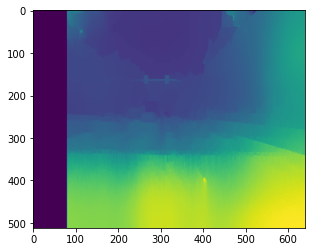

In [ ]:
# Ground truth
img_tr = Image.open('drive/MyDrive/CMU_Data_Full/disp/100.tiff').convert('L')
plt.imshow(img_tr)

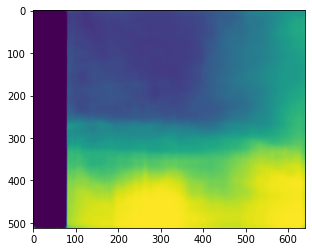

In [ ]:
# Predicted image
img_tst = Image.open('./image_download/100.tiff').convert('L')
plt.imshow(img_tst)

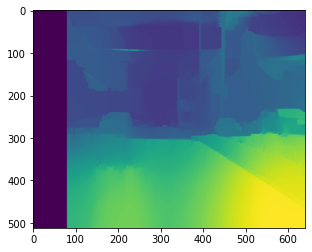

In [ ]:
# Ground truth
img_tr2 = Image.open('drive/MyDrive/CMU_Data_Full/disp/160.tiff').convert('L')
plt.imshow(img_tr2)

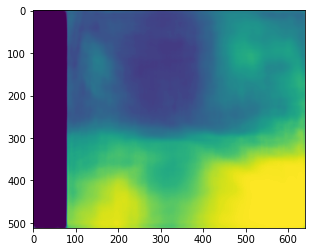

In [ ]:
# Predicted image
img_tst2 = Image.open('./image_download/160.tiff').convert('L')
plt.imshow(img_tst2)

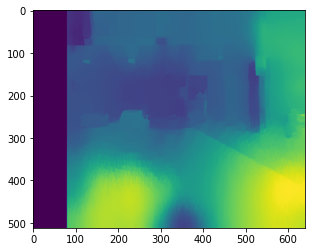

In [ ]:
# Ground truth
img_tr3 = Image.open('drive/MyDrive/CMU_Data_Full/disp/120.tiff').convert('L')
plt.imshow(img_tr3)

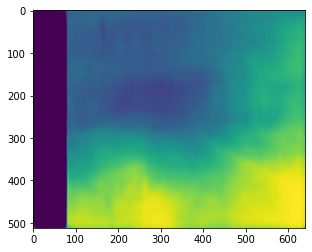

In [ ]:
# Predicted image
img_tst3 = Image.open('./image_download/120.tiff').convert('L')
plt.imshow(img_tst3)

**Zip the predicted images in a file and save model**

In [3]:
!zip -r /content/image_folder.zip /content/image_download

In [ ]:
torch.save(my_model,'/content/gdrive/My Drive/psmnetmodel')